# 实测六维数据和Baseline实验

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE # 导入SMOTE算法模块
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate # 交叉验证所需的函数
from sklearn.model_selection import KFold,LeaveOneOut,LeavePOut,ShuffleSplit # 交叉验证所需的子集划分方法
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit # 分层分割
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut,LeavePGroupsOut,GroupShuffleSplit # 分组分割
from sklearn.model_selection import TimeSeriesSplit # 时间序列分割
from sklearn import datasets  # 自带数据集
from sklearn import svm  # SVM算法
from sklearn import preprocessing  # 预处理模块
from sklearn.metrics import recall_score  # 模型度量

In [10]:
path = '/Users/amhu/jupyter_notebook/data/measure_inloc/final.csv'
data = pd.read_csv(path,encoding = "utf-8")

In [11]:
data.head()

,AP1,AP2,AP3,AP4,AP5,AP6,x,y
0,-67.00,-50.50,-72.80,-58.90,-67.90,-60.30,0.0,0.0
1,-65.17,-51.30,-71.87,-63.80,-68.13,-57.70,0.6,0.0
2,-72.80,-52.63,-71.07,-54.03,-70.67,-63.13,1.2,0.0
3,-58.13,-47.70,-75.27,-60.83,-66.37,-58.63,1.8,0.0
4,-56.10,-52.50,-71.83,-62.77,-64.60,-51.97,2.4,0.0


In [12]:
data.shape

(224, 8)

In [13]:
# create a python list of feature names
feature_cols = ['AP1', 'AP2', 'AP3','AP4','AP5','AP6']
# use the list to select a subset of the original DataFrame
X = data[feature_cols]
y = data[['x','y']]
# print the first 5 rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
train_data = pd.concat((X_train,y_train),axis = 1)

### 画图

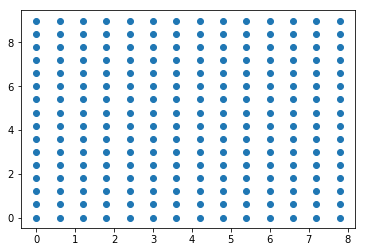

In [15]:
plt.scatter(data.iloc[:,[6]],data.iloc[:,[7]], marker = 'o')

In [16]:
all_info = data 

Text(0.5,0,'X')

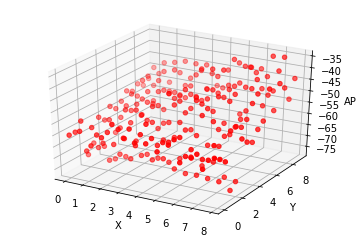

In [17]:
xx, yy, value = all_info[['x']], all_info[['y']], all_info[['AP6']]
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
ax.scatter(xx, yy, value, c='r')  # 绘制数据点
ax.set_zlabel('AP!')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')

### 搭建回归模型

In [18]:
def accuracy(predictions, labels):
    return np.mean(np.sqrt(np.sum((predictions - labels)**2, 1)))

### LR

In [24]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
print(linreg.intercept_)
print(linreg.coef_)

[25.42937732  7.81159064]
[[ 0.08251994 -0.02427024  0.21209649  0.07720944 -0.05891677  0.06334915]
 [-0.05391631 -0.02992613  0.01603803 -0.11951848  0.06994802  0.19923183]]


In [26]:
y_pred = linreg.predict(X_test)
accuracy(y_test, y_pred)

1.9763845328990675

## knn

In [27]:
ss_X=StandardScaler()
ss_y=StandardScaler()
X_train_ss=ss_X.fit_transform(X_train)
X_test_ss=ss_X.transform(X_test)

In [28]:
# knn回归
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(5, weights='distance')
%time knn_reg.fit(X_train_ss, y_train)
%time predictions_knn = knn_reg.predict(X_test_ss)

CPU times: user 1.81 ms, sys: 1.89 ms, total: 3.69 ms
Wall time: 7.54 ms
CPU times: user 1.92 ms, sys: 1.79 ms, total: 3.7 ms
Wall time: 3.47 ms


In [29]:
accuracy(y_test, predictions_knn)

1.5647276281992117

### RandomForest

In [30]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_estimators=150)
%time estimator.fit(X_train, y_train)
%time predictions = estimator.predict(X_test)
acc = accuracy(predictions, y_test)

CPU times: user 101 ms, sys: 2.85 ms, total: 104 ms
Wall time: 107 ms
CPU times: user 8.93 ms, sys: 486 µs, total: 9.42 ms
Wall time: 9.32 ms


### GBDT 

In [33]:
from sklearn import ensemble
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=10))
%time clf.fit(X_train, y_train)
%time predictions = clf.predict(X_test)
acc = accuracy(predictions, y_test)
acc

CPU times: user 98.7 ms, sys: 4.34 ms, total: 103 ms
Wall time: 102 ms
CPU times: user 2.01 ms, sys: 242 µs, total: 2.25 ms
Wall time: 2.83 ms


2.061728286662185

### 分类算法

### SVR

In [34]:
from sklearn import svm
labels = ((y_train.iloc[:,0]/0.6))*10 + (y_train.iloc[:,1]/0.6)
clf_svc = svm.SVC(C=1000, tol=0.01, gamma=0.001)

In [35]:
%time clf_svc.fit(X_train, np.round(labels))
%time preditction = clf_svc.predict(X_test)

CPU times: user 41.3 ms, sys: 3.99 ms, total: 45.3 ms
Wall time: 45.8 ms
CPU times: user 4.37 ms, sys: 238 µs, total: 4.61 ms
Wall time: 4.22 ms


In [36]:
x = np.floor(preditction//10)*0.6
y = np.floor(preditction%10)*0.6

In [37]:
predictions = np.column_stack((x, y))

In [38]:
accuracy(predictions, y_test)

3.6692946290145763

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
labels = ((y_train.iloc[:,0]/0.6))*10 + (y_train.iloc[:,1]/0.6)
estimator = RandomForestClassifier(n_estimators=20, max_features=None, max_depth=20) # 内存受限，tree的数量有点少
%time estimator.fit(X_train, np.round(labels))
%time predict_labels = estimator.predict(X_test)
x = np.floor(predict_labels//10)*0.6
y = np.floor(predict_labels%10)*0.6
predictions = np.column_stack((x, y)) 
accuracy(predictions, y_test)

CPU times: user 60.5 ms, sys: 3.49 ms, total: 63.9 ms
Wall time: 62.7 ms
CPU times: user 4.33 ms, sys: 1.48 ms, total: 5.81 ms
Wall time: 11 ms


4.300814093543771